<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L25-Node2Vec-RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a movie RecSys - Node2Vec

**MovieLens** dataset is a popular choice, with a small version of the latest dataset (09/2018) comprising 100,836 ratings, 9,742 movies, and 610 users.

In [1]:
!pip install -q node2vec
!pip install -qI gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 9.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [2]:
import pandas as pd

ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [3]:
movies = pd.read_csv('ml-100k/u.item', sep='|', usecols=range(2), names=['movie_id', 'title'], encoding='latin-1')
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [4]:
# Only consider ratings with the highest score
ratings = ratings[ratings.rating >= 4]
ratings

,user_id,movie_id,rating,unix_timestamp
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437


In [5]:
from collections import defaultdict

pairs = defaultdict(int)

# Loop through the entire list of users
for group in ratings.groupby("user_id"):
    # List of IDs of movies rated by the current user
    user_movies = list(group[1]["movie_id"])

    # Count every time two movies are seen together
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1

In [6]:
# Create a networkx graph
G = nx.Graph()

# Try to create an edge between movies that are liked together
for pair in pairs:
    movie1, movie2 = pair
    score = pairs[pair]

    # The edge is only created when the score is high enough
    if score >= 20:
        G.add_edge(movie1, movie2, weight=score)

print("Total number of graph nodes:", G.number_of_nodes())
print("Total number of graph edges:", G.number_of_edges())

Total number of graph nodes: 410
Total number of graph edges: 14936


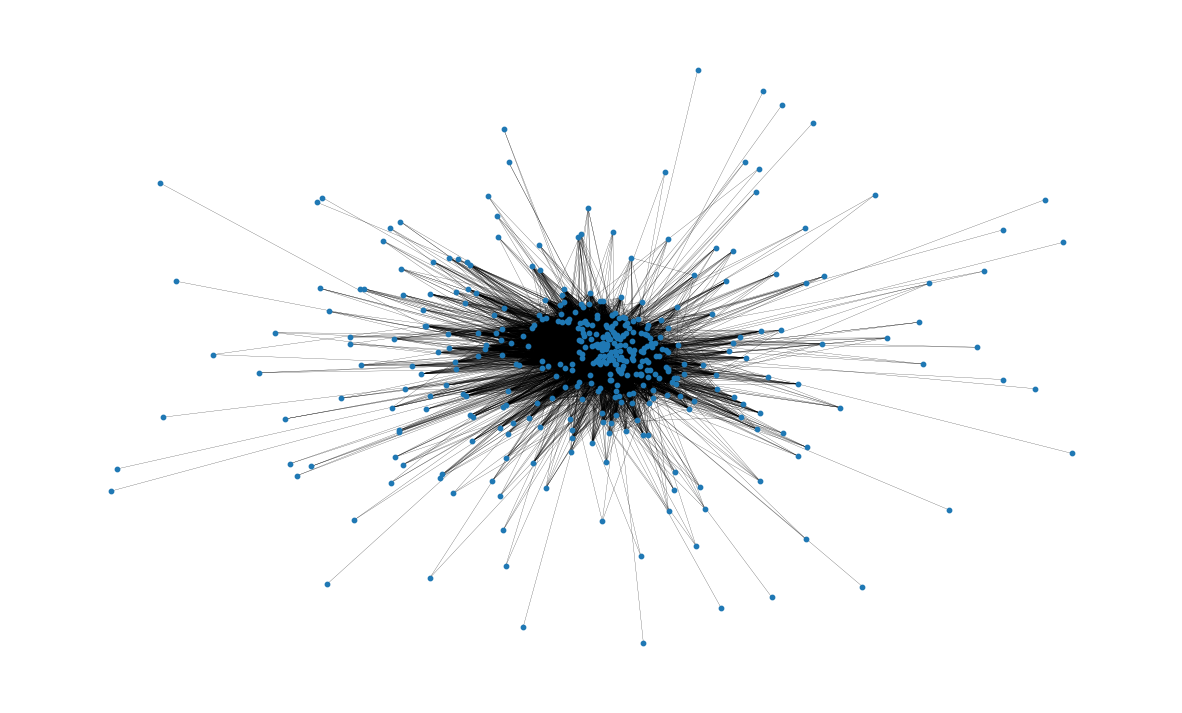

In [7]:
# Plot graph
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [8]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:27<00:00,  7.15it/s]


In [9]:
model.wv.index_to_key[0]

'50'

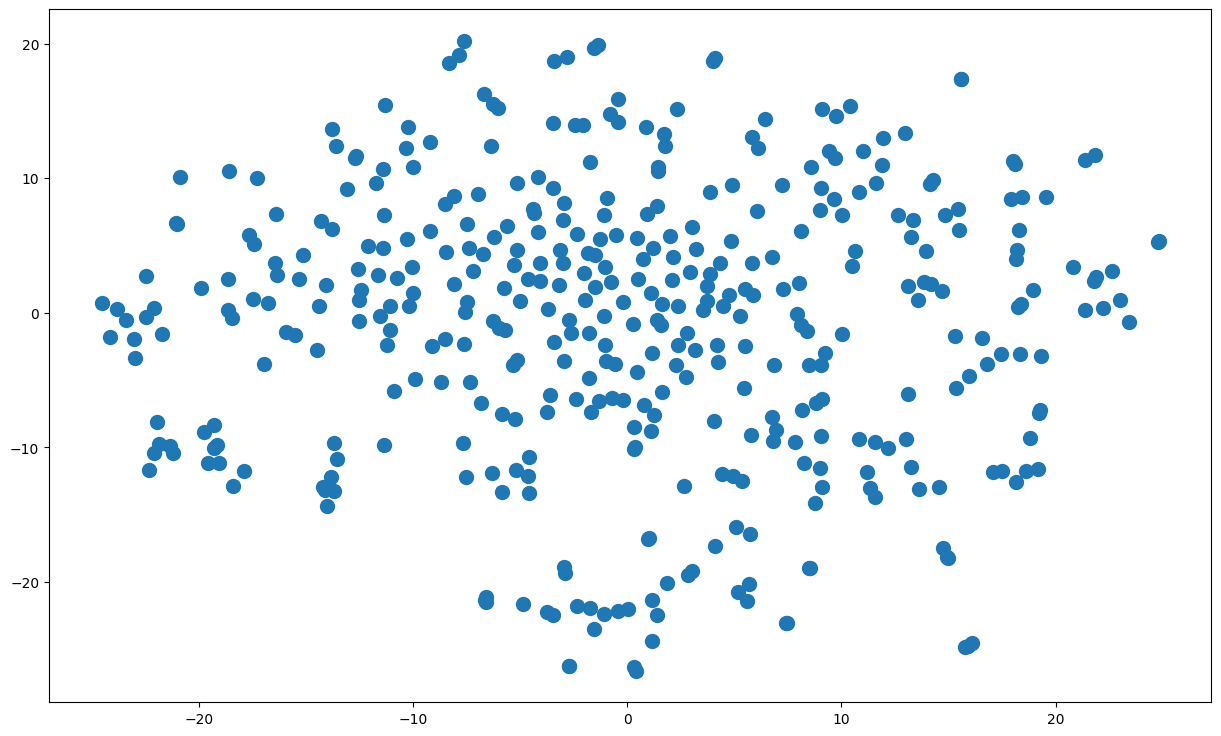

In [10]:
from sklearn.manifold import TSNE
import numpy as np

# Preprocess word vectors and label
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in model.wv.index_to_key])

# Train TSNE
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

# Plot TSNE
plt.figure(figsize=(15, 9))
plt.scatter(tsne[:, 0], tsne[:, 1], s=100)
plt.show()

In [11]:
def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f'{title}: {id[1]:.2f}')

recommend('Star Wars (1977)')

Raiders of the Lost Ark (1981): 0.59
Return of the Jedi (1983): 0.55
Monty Python and the Holy Grail (1974): 0.49
Indiana Jones and the Last Crusade (1989): 0.48
Amadeus (1984): 0.47


In [12]:
recommend('Toy Story (1995)')

Return of the Jedi (1983): 0.77
Twelve Monkeys (1995): 0.75
Independence Day (ID4) (1996): 0.61
Back to the Future (1985): 0.60
Indiana Jones and the Last Crusade (1989): 0.57


### Add info to nodes

In [13]:
movies[movies['movie_id'] == 61].title

,title
60,Three Colors: White (1994)


In [14]:
G.nodes[61]

{}

In [15]:
for node in G.nodes:
  G.nodes[node].update(movies[movies['movie_id'] == node].title)

In [16]:
G.nodes[61]

{60: 'Three Colors: White (1994)'}

plot new information (label)

In [17]:
def create_labels(movie):
  labels = []
  for node in G.nodes:
      label = [value for key, value in G.nodes[node].items()]
      labels.append(1 if label == [movie] else 0)
  return labels

In [18]:
def plot_labels(movie):
  # Train TSNE
  tsne = TSNE(n_components=2,
              learning_rate='auto',
              init='pca',
              random_state=0).fit_transform(nodes_wv)

  # Plot TSNE
  plt.figure(figsize=(15, 9))
  plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=create_labels(movie), cmap="coolwarm")
  plt.show()

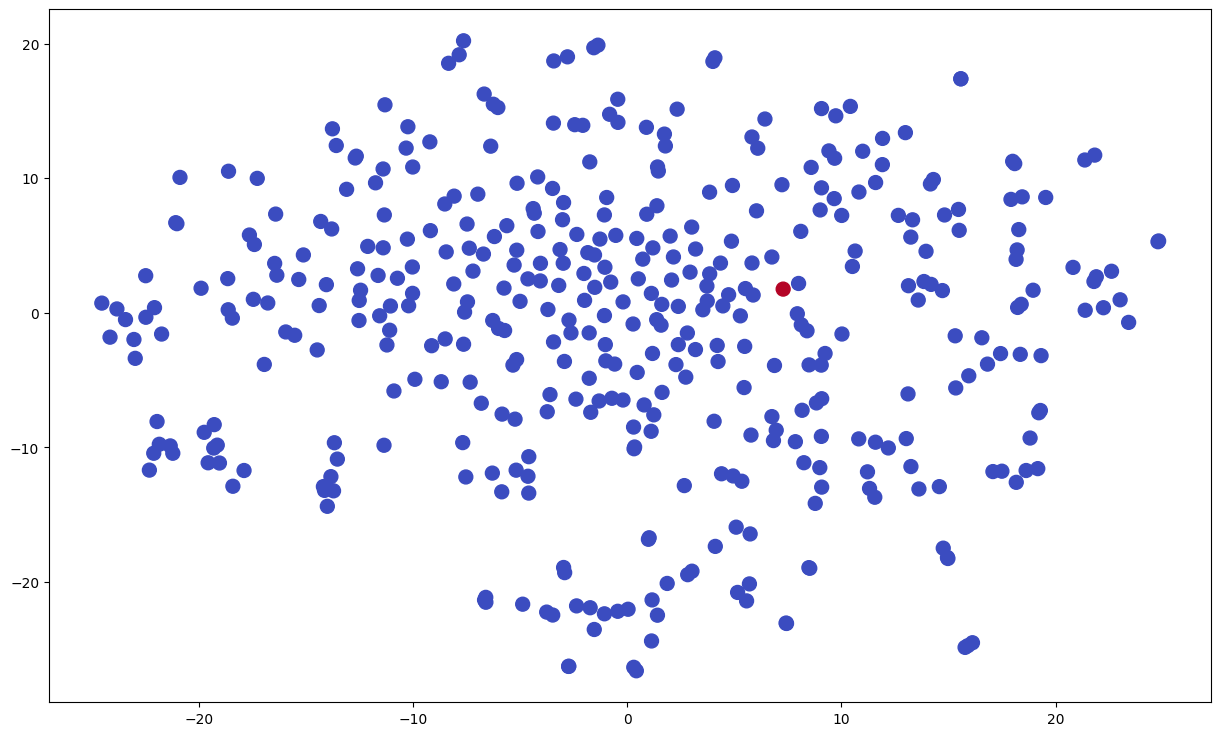

In [19]:
plot_labels('Star Wars (1977)')

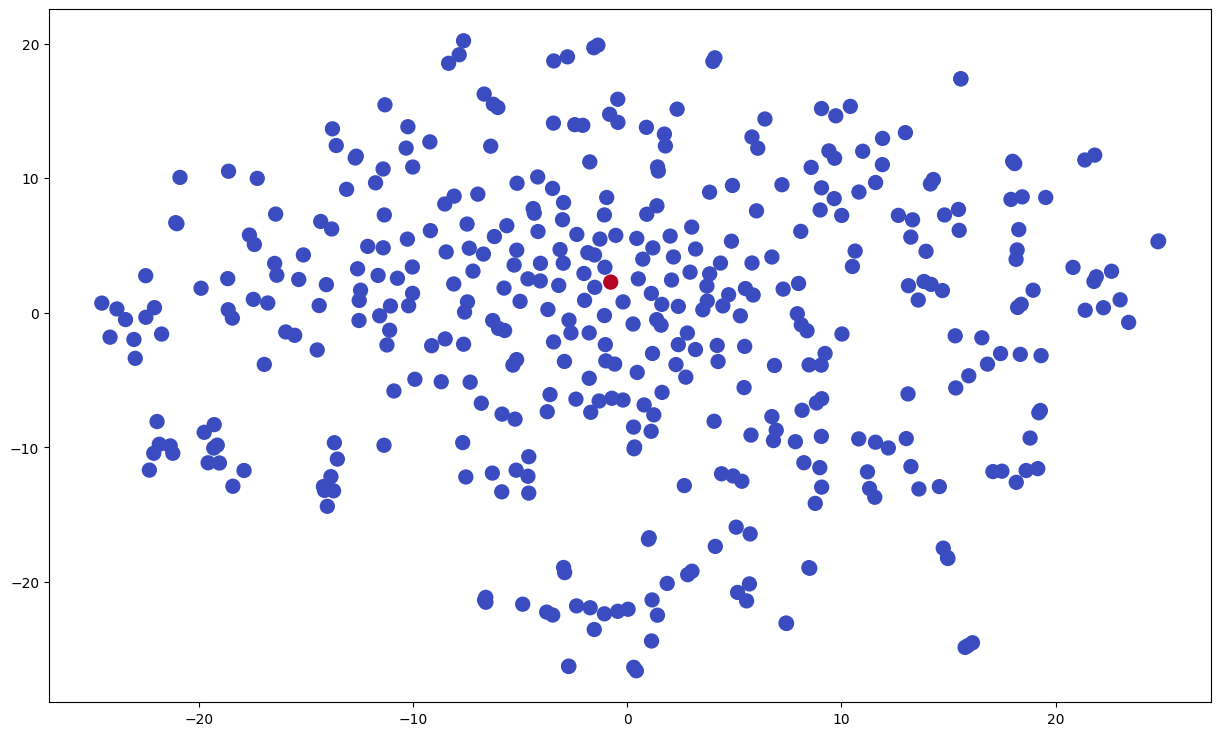

In [20]:
plot_labels('Toy Story (1995)')

Now, plot all information in TNSE

In [21]:
def create_labels(movie, top_n=5):
    labels = []

    # Obtienes el ID de la película seleccionada (como string)
    movie_id = str(movies[movies.title == movie].movie_id.values[0])

    # Obtienes IDs recomendados
    recommended_ids = [id[0] for id in model.wv.most_similar(movie_id, topn=top_n)]

    for node in G.nodes:
        node_id = str(node)
        if node_id == movie_id:
            labels.append(2)  # la película seleccionada
        elif node_id in recommended_ids:
            labels.append(1)  # películas recomendadas
        else:
            labels.append(0)  # todas las demás películas
    return labels

In [22]:
def plot_labels(movie):
    # Creamos TSNE
    tsne = TSNE(n_components=2, learning_rate='auto',
                init='pca', random_state=0).fit_transform(nodes_wv)

    # Creamos etiquetas (labels) usando la nueva función
    labels = create_labels(movie)

    # Mapeamos labels a colores claramente distinguibles
    colors = ['lightgrey', 'cornflowerblue', 'red']  # 0: resto, 1: recomendadas, 2: seleccionada
    labels_names = ["Resto películas", "Películas recomendadas", "Película seleccionada"]

    # Trama TSNE con colores claramente diferenciados
    plt.figure(figsize=(15, 10))
    for label in [0, 1, 2]:
        idx = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(tsne[idx, 0], tsne[idx, 1],
                    c=colors[label], label=labels_names[label],
                    alpha=0.9 if label > 0 else 0.4,  # más transparente el grupo masivo (0)
                    edgecolor='k' if label == 2 else 'none',
                    s=150 if label == 2 else 80)

    plt.title(f"Distribución vectorial t-SNE: '{movie}' y películas relacionadas", fontsize=16)
    plt.legend(fontsize=13)
    plt.grid(alpha=0.3)
    plt.show()

Return of the Jedi (1983): 0.77
Twelve Monkeys (1995): 0.75
Independence Day (ID4) (1996): 0.61
Back to the Future (1985): 0.60
Indiana Jones and the Last Crusade (1989): 0.57


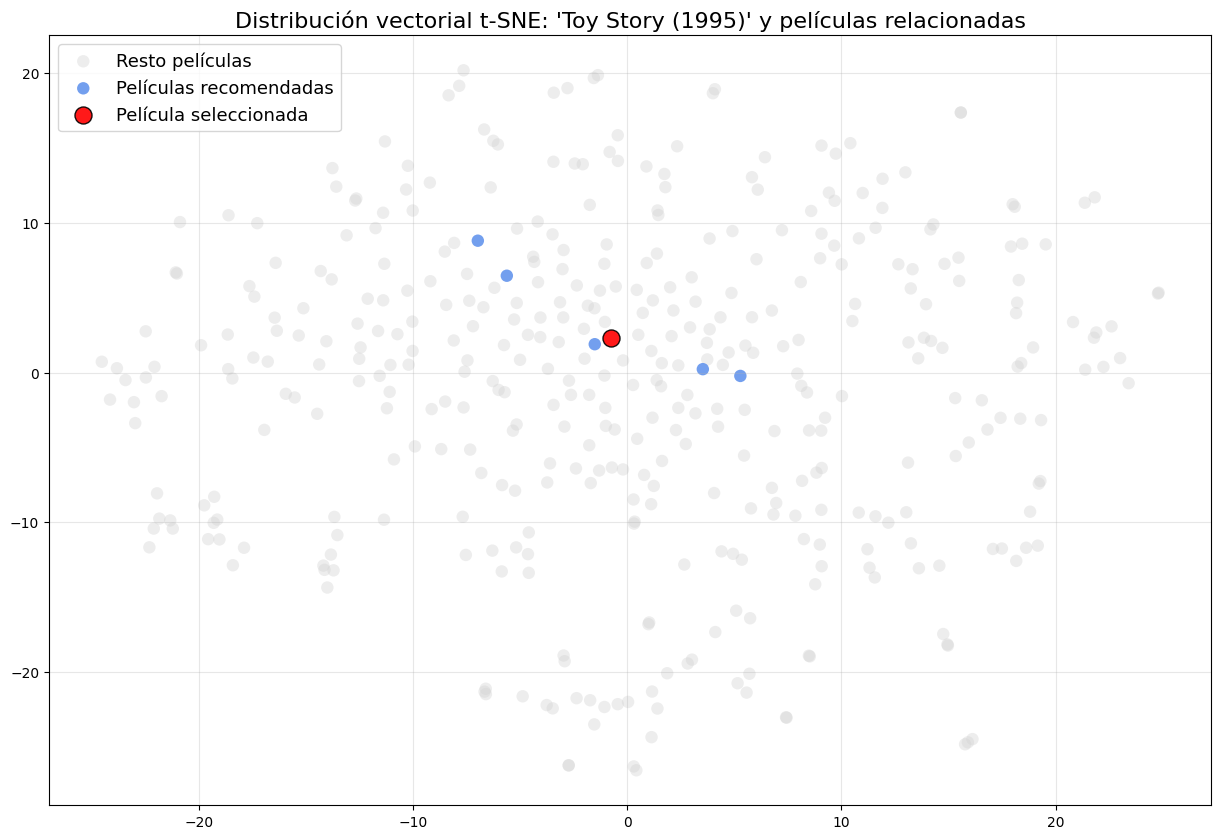

In [23]:
movie = "Toy Story (1995)"
recommend(movie)
plot_labels(movie)

Raiders of the Lost Ark (1981): 0.59
Return of the Jedi (1983): 0.55
Monty Python and the Holy Grail (1974): 0.49
Indiana Jones and the Last Crusade (1989): 0.48
Amadeus (1984): 0.47


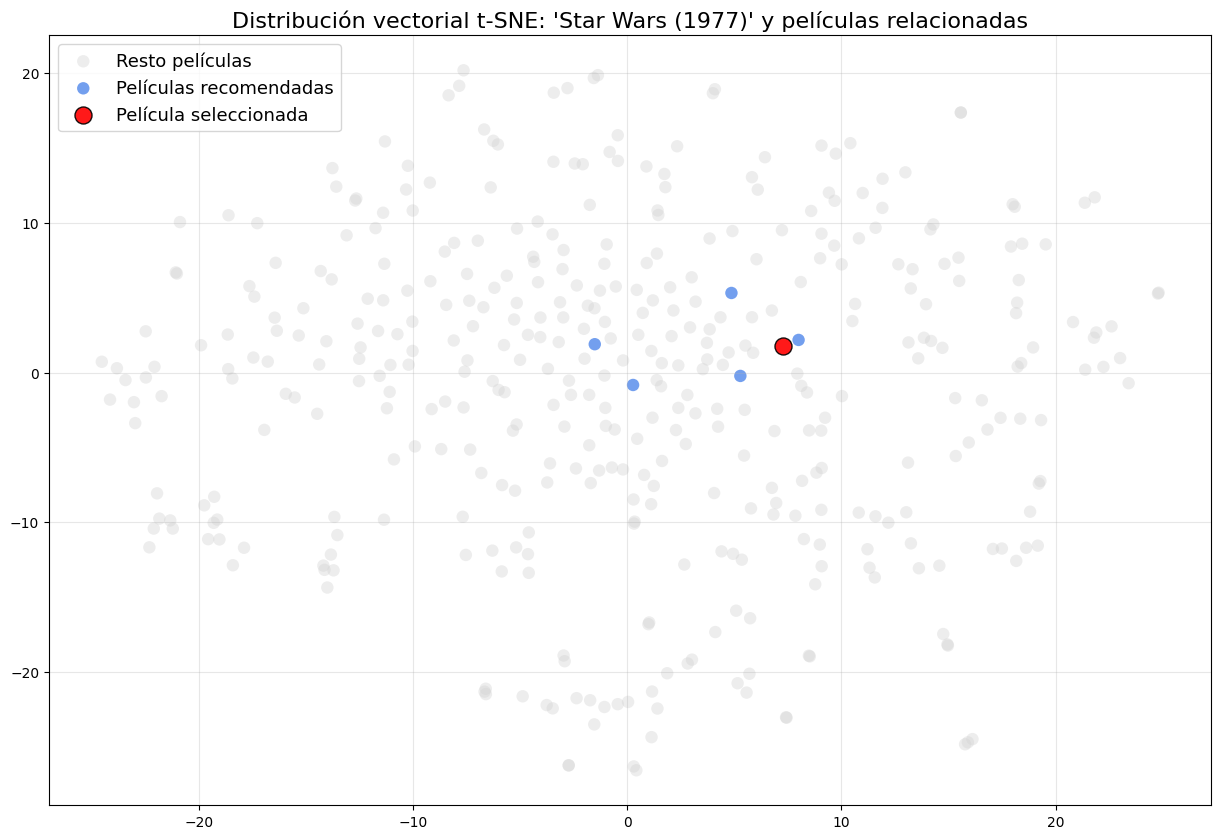

In [24]:
movie = 'Star Wars (1977)'
recommend(movie)
plot_labels(movie)